In [1]:
import sys
sys.path.append('../../')
import os
import dill
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import PDController
from core.dynamics import LinearSystemDynamics, ConfigurationDynamics

from koopman_core.controllers import OpenLoopController, MPCController,BilinearFBLinController, PerturbedController, LinearLiftedController
from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd, BilinearEdmd, KoopDnn
from koopman_core.basis_functions import PlanarQuadBasis
from koopman_core.learning.utils import differentiate_vec
from koopman_core.systems import PlanarQuadrotorForceInput

class QuadrotorPdOutput(ConfigurationDynamics):
    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]

class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt
        
    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin
    

## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [2]:
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
sys_name = 'planar_quad'
system = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

# Linearized system specification:
n, m = 6, 2                                                         # Number of states, number of control inputs
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.



In [3]:
q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
collect_data = False
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_train = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_train = 200                                                     # Number of trajectories to execute, data collection
n_traj_val = int(0.2*n_traj_train)
noise_var = 10.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust]) - hover_thrust    # Actuation constraint, trajectory generation
umin = np.array([0., 0.]) - hover_thrust
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = 'examples/planar_quad_models'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
save_figures = True
directory = os.path.abspath("")                                     # Path to save learned models
#dropbox_folder = '/Users/carlaxelfolkestad/Dropbox/Apps/Overleaf/Koopman NMPC (ICRA21)/'

In [4]:
if collect_data:
    xd = np.empty((n_traj_train + n_traj_val, n_pred_dc + 1, n))
    xs = np.empty((n_traj_train + n_traj_val, n_pred_dc + 1, n))
    us = np.empty((n_traj_train + n_traj_val, n_pred_dc, m))

    plt.figure(figsize=(12, 12 * (n_traj_train + n_traj_val) / (n_cols ** 2)))
    for ii in range(n_traj_train+n_traj_val):
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd[ii, :, :] = mpc_trajgen.parse_result().T
        while abs(x0[0]) + abs(x0[1]) < 1 or np.any(np.isnan(xd[ii, :, :])):
            x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
            set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
            mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                        QN_trajgen, set_pt_dc)
            mpc_trajgen.eval(x0, 0)
            xd[ii, :, :] = mpc_trajgen.parse_result().T

        output = QuadrotorPdOutput(system, xd[ii, :, :], t_train, n, m)
        pd_controller = PDController(output, K_dc_p, K_dc_d)
        perturbed_pd_controller = PerturbedController(system, pd_controller, noise_var, const_offset=hover_thrust)
        xs[ii, :, :], us[ii, :, :] = system.simulate(x0, perturbed_pd_controller, t_train)

        plt.subplot(int(np.ceil((n_traj_train + n_traj_val) / n_cols)), n_cols, ii + 1)
        plt.plot(t_train, xs[ii, :, 0], 'b', label='$y$')
        plt.plot(t_train, xs[ii, :, 1], 'g', label='$z$')
        plt.plot(t_train, xs[ii, :, 2], 'r', label='$\\theta$')
        plt.plot(t_train, xd[ii, :, 0], '--b', label='$y_d$')
        plt.plot(t_train, xd[ii, :, 1], '--g', label='$z_d$')
        plt.plot(t_train, xd[ii, :, 2], '--r', label='$\\theta_d$')

    plt.suptitle(
        'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
        y=0.94)
    plt.show()

    xs_train, us_train = xs[:n_traj_train,:,:], us[:n_traj_train, :, :]
    xs_val, us_val = xs[n_traj_train:,:,:], us[n_traj_train:, :, :]
    
    data_list = [xs_train, us_train, t_train, n_traj_train, xs_val, us_val, t_train, n_traj_val]
    outfile = open(directory + '/data/' + sys_name + '_data.pickle', 'wb')
    dill.dump(data_list, outfile)
    outfile.close()
else:
    infile = open(directory + '/data/' + sys_name + '_data.pickle', 'rb')
    xs_train, us_train, t_train, n_traj_train, xs_val, us_val, t_val, n_traj_val = dill.load(infile)
    infile.close()

### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}

In [5]:
#DMD parameters:
alpha_dmd = 9.8e-5                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [6]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_train, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, 
                 first_obs_const=False, continuous_mdl=False, dt=dt)
xdmd, y_dmd = model_dmd.process(xs_train, us_train-hover_thrust, np.tile(t_train,(n_traj_train,1)), 
                                downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [7]:
#EDMD parameters:
alpha_edmd = 2.22e-4                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [8]:
basis = PlanarQuadBasis(n, poly_deg=3)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_edmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', 
                                             max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_train, optimizer_edmd, cv=cv_edmd, 
                  standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs_train, us_train-hover_thrust, np.tile(t_train,(n_traj_train,1)), 
                                    downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
model_edmd.reduce_mdl()
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis_reduced, 
                                continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)

Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [9]:
#Bilinear EDMD parameters:                                           
alpha_bedmd = 6.9e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [10]:
n_lift_bedmd = n_lift_edmd
C_bedmd = np.zeros((n,n_lift_bedmd))
C_bedmd[:,1:n+1] = np.eye(n)

basis_bedmd = lambda x: planar_quad_features.transform(x)
optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random')
cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_train, optimizer_bedmd, cv=cv_bedmd, 
                           standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
X_bedmd, y_bedmd = model_bedmd.process(xs_train, us_train, np.tile(t_train,(n_traj_train,1)), 
                                       downsample_rate=sub_sample_rate)
model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, 
                                   model_bedmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_bedmd:
    print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)
    

/Users/carlaxelfolkestad/.conda/envs/keedmd/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1790: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7994093491222793, tolerance: 0.0748879035072359
  check_random_state(self.random_state), random)


### Learn a lifted bilinear model with Koopman NN

In [11]:
import dill, os, torch

load_tuned_params = False

if load_tuned_params:
    infile = open(os.path.abspath('') + '/data/planar_quad_best_params.pickle', 'rb')
    net_params, val_loss, test_loss, open_loop_mse, open_loop_std = dill.load(infile)
    infile.close()

else:
    net_params = {}
    net_params['state_dim'] = n
    net_params['ctrl_dim'] = m
    net_params['encoder_hidden_width'] = 100
    net_params['encoder_hidden_depth'] = 2
    net_params['encoder_output_dim'] = 10
    net_params['optimizer'] = 'adam'
    net_params['activation_type'] = 'tanh'
    net_params['lr'] = 1e-3
    net_params['epochs'] = 50
    net_params['batch_size'] = 256
    net_params['lin_loss_penalty'] = 0.8
    net_params['l2_reg'] = 0
    net_params['l1_reg'] = 0
    net_params['first_obs_const'] = True
    net_params['override_kinematics'] = True 
    net_params['dt'] = dt

print(net_params)

{'state_dim': 6, 'ctrl_dim': 2, 'encoder_hidden_width': 100, 'encoder_hidden_depth': 2, 'encoder_output_dim': 10, 'optimizer': 'adam', 'activation_type': 'tanh', 'lr': 0.001, 'epochs': 50, 'batch_size': 256, 'lin_loss_penalty': 0.8, 'l2_reg': 0, 'l1_reg': 0, 'first_obs_const': True, 'override_kinematics': True, 'dt': 0.01}


In [12]:
print(net_params)

{'state_dim': 6, 'ctrl_dim': 2, 'encoder_hidden_width': 100, 'encoder_hidden_depth': 2, 'encoder_output_dim': 10, 'optimizer': 'adam', 'activation_type': 'tanh', 'lr': 0.001, 'epochs': 50, 'batch_size': 256, 'lin_loss_penalty': 0.8, 'l2_reg': 0, 'l1_reg': 0, 'first_obs_const': True, 'override_kinematics': True, 'dt': 0.01}


In [13]:
from koopman_core.learning import KoopDnn, KoopmanNetCtrl
from koopman_core.util import fit_standardizer

standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler())
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler())
n_tot = n + net_params['encoder_output_dim'] + int(net_params['first_obs_const'])

net = KoopmanNetCtrl(net_params, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
model_koop_dnn = KoopDnn(net)
model_koop_dnn.set_datasets(xs_train, t_train, u_train=us_train, x_val=xs_val, u_val=us_val, t_val=t_train)
model_koop_dnn.model_pipeline(net_params)
model_koop_dnn.construct_koopman_model()
sys_koop_dnn = BilinearLiftedDynamics(n_tot, m, model_koop_dnn.A, model_koop_dnn.B, model_koop_dnn.C, model_koop_dnn.basis_encode,
                                    continuous_mdl=False, dt=dt, standardizer_x=standardizer_x_kdnn, 
                                      standardizer_u=standardizer_u_kdnn)

Epoch   1: train loss: 7.62606812, validation loss: 0.74469427
Epoch   2: train loss: 0.47208852, validation loss: 0.31851006
Epoch   3: train loss: 0.23529103, validation loss: 0.18433264
Epoch   4: train loss: 0.14286804, validation loss: 0.12416704
Epoch   5: train loss: 0.09762967, validation loss: 0.09423529
Epoch   6: train loss: 0.07308902, validation loss: 0.07309832
Epoch   7: train loss: 0.05884780, validation loss: 0.06198906
Epoch   8: train loss: 0.04931774, validation loss: 0.05260272
Epoch   9: train loss: 0.04221152, validation loss: 0.04487944
Epoch  10: train loss: 0.03654315, validation loss: 0.03918108
Epoch  11: train loss: 0.03188878, validation loss: 0.03492119
Epoch  12: train loss: 0.02811481, validation loss: 0.03163124
Epoch  13: train loss: 0.02518061, validation loss: 0.02697615
Epoch  14: train loss: 0.02226443, validation loss: 0.02403816
Epoch  15: train loss: 0.02012405, validation loss: 0.02185189
Epoch  16: train loss: 0.01841855, validation loss: 0.0

### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [14]:
# Prediction performance evaluation parameters:
folder_plots = 'figures/'                                  # Path to save plots
n_traj_ol = 50                                                     # Number of trajectories to execute, open loop
t_eval = t_train

In [15]:
from koopman_core.util import evaluate_ol_pred
from tabulate import tabulate

xs_test = np.empty((n_traj_ol, t_eval.shape[0], n))
us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                QN_trajgen, set_pt_dc)
    mpc_trajgen.eval(x0, 0)
    xd = mpc_trajgen.parse_result().T

    while xd[0,0] is None:
        x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
        mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
                                    QN_trajgen, set_pt_dc)
        mpc_trajgen.eval(x0, 0)
        xd = mpc_trajgen.parse_result().T

    output = QuadrotorPdOutput(system, xd, t_eval, n, m)
    pd_controller = PDController(output, K_dc_p, K_dc_d)
    perturbed_pd_controller = PerturbedController(system, pd_controller, noise_var, const_offset=hover_thrust)
    
    xs_test[ii,:,:], us_test[ii,:,:] = system.simulate(x0, perturbed_pd_controller, t_eval)
    
    mdl_lst = [sys_dmd, sys_edmd, sys_bedmd, sys_koop_dnn]
    u_data_lst = [us_test-hover_thrust, us_test-hover_thrust, us_test, us_test]
    mdl_names = ['DMD', 'EDMD', 'bEDMD', 'Koop DNN']
    error, mse, std = [], [], []
    
    for sys, u_data in zip(mdl_lst, u_data_lst):
        err_tmp, mse_tmp, std_tmp = evaluate_ol_pred(sys, xs_test, t_eval, us=u_data)
        error.append(err_tmp)
        mse.append(mse_tmp)
        std.append(std_tmp)

print('\nOpen loop performance statistics:')
table_data = []
for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
    table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

print(tabulate(table_data, 
               headers=['Mean squared error', 'Standard deviation']))


Open loop performance statistics:
            Mean squared error    Standard deviation
--------  --------------------  --------------------
DMD                    0.09233               0.29942
EDMD                   0.04571               0.2096
bEDMD                  0.00214               0.046
Koop DNN               0.02246               0.1472


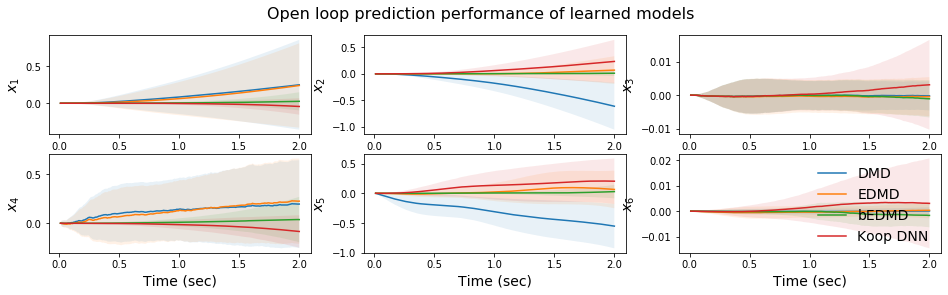

In [16]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 16
lw = 2
fs = 14
y_lim_gain = 1.2
row = 2
col = n/row

#Plot open loop results:
plt.figure(figsize=(figwidth,4))
axs = [plt.subplot(row,col,jj+1) for jj in range(n)]

for ii, err in enumerate(error):
    err_mean = np.mean(err, axis=0)
    err_std = np.std(err, axis=0)
    
    for jj in range(n):
        axs[jj].plot(t_eval[1:], err_mean[:,jj], label=mdl_names[ii])
        axs[jj].fill_between(t_eval[1:], err_mean[:,jj]-err_std[:,jj], err_mean[:,jj]+err_std[:,jj], alpha=0.1)

for jj in range(n):
    axs[jj].set_xlabel('Time (sec)', fontsize=fs)
    axs[jj].set_ylabel('$x_'+ str(jj+1) + '$', fontsize=fs)

plt.legend(frameon=False, fontsize=fs)
stitle=plt.suptitle('Open loop prediction performance of learned models', fontsize=fs+2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig(folder_plots + 'koop_sys_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(stitle,), bbox_inches="tight")
plt.show()

# Design trajectories based on learned models

We now study the closed loop performance of the control design. 

In [17]:
#Closed loop performance evaluation parameters:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
#QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
QN_mpc = Q_mpc
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation

ctrl_offset = np.array([hover_thrust, hover_thrust])

# Design trajectory:
x0_cl = np.array([0., 0., 0., 0., 0., 0.])                   # Initial value, closed loop trajectory
set_pt_cl = np.array([1.5, 0.5, 0., 0., 0., 0.])              # Desired final value, closed loop trajectory
xmax = np.array([2, 2, np.pi/3, 1.,1.,1.])                          # State constraints, trajectory generation
xmin = -xmax
term_constraint=True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0_cl, set_pt_cl, int(traj_length)+1)
u_init = hover_thrust*np.ones((m,traj_length)).T

#### Design controllers for learned DMD, EDMD, and bEDMD models

In [18]:
from koopman_core.controllers import MPCController, NonlinearMPCController, BilinearMPCController

# Define DMD-based controller:
controller_dmd = MPCController(sys_dmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint, const_offset=ctrl_offset)

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCController(sys_bedmd, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)
z0_cl = sys_bedmd.basis(x0_cl.reshape((1,-1))).squeeze()
z_init = sys_bedmd.basis(x_init)
controller_bedmd.construct_controller(z_init, u_init)

# Define KDNN-based controller:
controller_kdnn = BilinearMPCController(sys_koop_dnn, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, 
                                        terminal_constraint=term_constraint, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
z0_cl_kdnn = sys_koop_dnn.basis(x0_cl.reshape((1,-1))).squeeze()
z_init_kdnn = sys_koop_dnn.basis(x_init)
u_init_kdnn = standardizer_u_kdnn.transform(u_init)
controller_kdnn.construct_controller(z_init_kdnn, u_init_kdnn)

#### Design controller using full knowledge of nonlinear controller

In [19]:
system_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCController(system_d, traj_length, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init+hover_thrust)

#### Design trajectories with the contructed MPCs

In [20]:
max_iter = 50

controller_dmd.eval(x0_cl, 0)
xr_dmd = controller_dmd.parse_result()
ur_dmd = controller_dmd.get_control_prediction() + hover_thrust

controller_edmd.eval(x0_cl, 0)
xr_edmd = sys_edmd.C@controller_edmd.parse_result()
ur_edmd = controller_edmd.get_control_prediction() + hover_thrust

controller_bedmd.solve_to_convergence(z0_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = sys_bedmd.C@controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T

controller_kdnn.solve_to_convergence(z0_cl_kdnn, 0., z_init_kdnn, u_init_kdnn, max_iter=max_iter)
xr_kdnn = standardizer_x_kdnn.inverse_transform((sys_koop_dnn.C@controller_kdnn.get_state_prediction().T).T).T
ur_kdnn = controller_kdnn.get_control_prediction().T

In [21]:
controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init + ctrl_offset.reshape(1,-1), max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open loop

In [22]:
ol_controller_dmd = OpenLoopController(system, ur_dmd.T, t_eval[:-1])
xs_dmd, us_dmd = system.simulate(x0_cl, ol_controller_dmd, t_eval)
xs_dmd, us_dmd = xs_dmd.T, us_dmd.T

ol_controller_edmd = OpenLoopController(system, ur_edmd.T, t_eval[:-1])
xs_edmd, us_edmd = system.simulate(x0_cl, ol_controller_edmd, t_eval)
xs_edmd, us_edmd = xs_edmd.T, us_edmd.T

ol_controller_bedmd = OpenLoopController(system, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = system.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_kdnn = OpenLoopController(system, ur_kdnn.T, t_eval[:-1])
xs_kdnn, us_kdnn = system.simulate(x0_cl, ol_controller_kdnn, t_eval)
xs_kdnn, us_kdnn = xs_kdnn.T, us_kdnn.T

ol_controller_nmpc = OpenLoopController(system, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = system.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

##### Compare performance

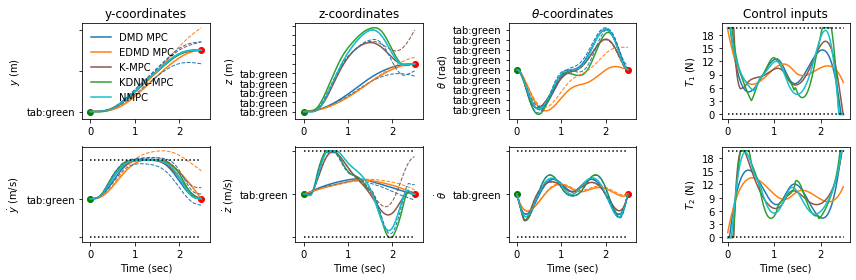

Solution statistics:

                       Normalized cost,    Realized terminal,  # of SQP      Mean comp. time           Total comp.
                    designed trajectory                 error  iterations    per iteration (secs)      time (secs)
----------------  ---------------------  --------------------  ------------  ----------------------  -------------
DMD MPC                          0.9255                0.4113  -             -                            0.258342
EDMD MPC                         0.8521                0.9221  -             -                            4.38494
bEDMD MPC                        1.0182                0.994   20            2.3746                      47.4918
KDNN MPC                         1.0669                0.3353  10            1.1693                      11.6929
NMPC (benchmark)                 1                     0.0182  9             0.1773                       1.59559


In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plot_inds = [0, 1, 2, 3, 4, 5, 0, 1]
subplot_inds = [1, 2, 3, 5, 6, 7, 4, 8]
labels = ['$y$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{y}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
titles = ['y-coordinates', 'z-coordinates', '$\\theta$-coordinates', 'Control inputs']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:green', 'tab:cyan']

plt.figure(figsize=(12,4))
#plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval, xr_dmd[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval, xr_edmd[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval, xr_bedmd[ind, :], colors[2], label='K-MPC')
        plt.plot(t_eval, xr_kdnn[ind, :], colors[3], label='KDNN-MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[4], label='NMPC')

        plt.plot(t_eval, xs_dmd[ind,:], '--', color=colors[0], linewidth=1)
        plt.plot(t_eval, xs_edmd[ind, :], '--', color=colors[1], linewidth=1)
        plt.plot(t_eval, xs_bedmd[ind, :], '--', color=colors[2], linewidth=1)
        plt.plot(t_eval, xs_kdnn[ind, :], '--',  colors[3], linewidth=1)
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[4], linewidth=1)

        plt.scatter(t_eval[0], x0_cl[ind], color='g')
        plt.scatter(t_eval[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if ii >= 3:
            plt.plot([0, t_eval[-1]], [xmax[ind], xmax[ind]], ':k')
            plt.plot([0, t_eval[-1]], [xmin[ind], xmin[ind]], ':k')
            #plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    elif ii < 8:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_dmd[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval[:-1], ur_edmd[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval[:-1], ur_bedmd[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval[:-1], ur_kdnn[ind, :], color=colors[3], label='KDNN-NMPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[4], label='NMPC')
        plt.plot([0, t_eval[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    if subplot_inds[ii] > 4:
        plt.xlabel('Time (sec)')
    else:
        plt.title(titles[subplot_inds[ii]-1])

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    #plt.savefig(dropbox_folder + 'planar_quad_trajectory.pdf', format='pdf', dpi=2400)
plt.show()

cost_ref_dmd = (xr_dmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_dmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_dmd.T@R_mpc@ur_dmd))
cost_ref_edmd = (xr_edmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_edmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_edmd.T@R_mpc@ur_edmd))
cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_kdnn = (xr_kdnn[:,-1]-set_pt_cl).T@QN_mpc@(xr_kdnn[:,-1]-set_pt_cl) + np.sum(np.diag(ur_kdnn.T@R_mpc@ur_kdnn))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

dist_ol_dmd = np.linalg.norm(xs_dmd[:,-1] - set_pt_cl)
dist_ol_edmd = np.linalg.norm(xs_edmd[:,-1] - set_pt_cl)
dist_ol_bedmd = np.linalg.norm(xs_bedmd[:,-1] - set_pt_cl)
dist_ol_kdnn = np.linalg.norm(xs_kdnn[:,-1] - set_pt_cl)
dist_ol_nmpc = np.linalg.norm(xs_nmpc[:,-1] - set_pt_cl)

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_ref_dmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_dmd), '-','-',sum(controller_dmd.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_ref_edmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_edmd),'-','-',sum(controller_edmd.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_bedmd), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['KDNN MPC', "{:.4f}".format(cost_ref_kdnn/cost_ref_nmpc), "{:.4f}".format(dist_ol_kdnn), len(controller_kdnn.x_iter), "{:.4f}".format(np.mean(controller_kdnn.comp_time)), sum(controller_kdnn.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(dist_ol_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]], 
               headers=['Normalized cost,\ndesigned trajectory', 'Realized terminal,\nerror', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

In [24]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(system, u_init, t_eval[:-1])
xs_init, _ = system.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_kdnn = [init_cost]
iter_cost_nmpc = [init_cost]
iter_norm_dist_bedmd = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_kdnn = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_nmpc = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T
    ol_controller_bedmd_iter = OpenLoopController(system, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = system.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    iter_norm_dist_bedmd.append(np.linalg.norm(xs_bedmd_iter[:,-1]-set_pt_cl))
    
for ii in range(len(controller_kdnn.x_iter)):
    ur_kdnn_iter = standardizer_u_kdnn.inverse_transform(controller_kdnn.u_iter[ii].T)
    ol_controller_kdnn_iter = OpenLoopController(system, ur_kdnn_iter, t_eval[:-1])
    xs_kdnn_iter, _ = system.simulate(x0_cl, ol_controller_kdnn_iter, t_eval)
    xs_kdnn_iter, us_kdnn_iter = xs_kdnn_iter.T, ur_kdnn_iter.T
    iter_cost_kdnn.append((xs_kdnn_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_kdnn_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_kdnn_iter.T@R_mpc@us_kdnn_iter)))
    iter_norm_dist_kdnn.append(np.linalg.norm(xs_kdnn_iter[:,-1]-set_pt_cl))
    
for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(system, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = system.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))
    iter_norm_dist_nmpc.append(np.linalg.norm(xs_nmpc_iter[:,-1]-set_pt_cl))

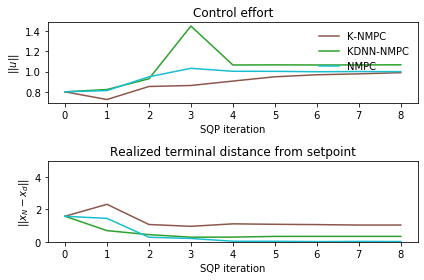

Solution statistics

                            Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                               iterations       iteration (secs)      iteration (secs)    time (secs)
------------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                           9               0.177287              0.123062        1.59559
Koopman bilinear MPC                   20               2.37459               2.13495        47.4918
Koopman DNN bilinear MPC               10               1.16929               0.924678       11.6929


In [25]:
plt.figure(figsize=(6,4))
#plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], color=colors[2], label='K-NMPC')
plt.plot(np.arange(n_iter), iter_cost_kdnn[:n_iter]/iter_cost_nmpc[-1], color=colors[3], label='KDNN-NMPC')
plt.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], color=colors[4], label='NMPC')
plt.title('Control effort')
plt.ylabel('$||u||$')
plt.legend(loc='upper right', frameon=False)
plt.xlabel('SQP iteration')

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), iter_norm_dist_bedmd[:n_iter], color=colors[2], label=labels[2])
plt.plot(np.arange(n_iter), iter_norm_dist_kdnn[:n_iter], color=colors[3], label=labels[3])
plt.plot(np.arange(n_iter), iter_norm_dist_nmpc[:n_iter], color=colors[4], label=labels[4])
plt.ylim(0,5)
plt.title('Realized terminal distance from setpoint')
plt.ylabel('$||x_N - x_d||$')
plt.xlabel('SQP iteration')

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    #plt.savefig(dropbox_folder + 'planar_quad_sqp_iterations.pdf', format='pdf', dpi=2400)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)],
                ['Koopman DNN bilinear MPC', len(controller_kdnn.x_iter), np.mean(controller_kdnn.comp_time), np.std(controller_kdnn.comp_time), sum(controller_kdnn.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [26]:
from koopman_core.controllers import PerturbedController

Q_mpc_cl = 5e2*np.diag([1, 1, 1, 2e-1, 2e-1, 2e-1])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 1.
N_cl = int(traj_duration/dt)
t_eval_cl=np.arange(300)*dt

# Solver settings closed loop:
polish_osqp = False
max_iter_osqp = 10
linsys_solver_osqp = 'qdldl'
warm_start_osqp = True

controller_dmd_cl = MPCController(sys_dmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_dmd_cl = PerturbedController(sys_dmd,controller_dmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_edmd_cl = MPCController(sys_edmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_edmd_cl = PerturbedController(sys_edmd,controller_edmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_bedmd_cl = BilinearMPCController(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)
controller_bedmd_cl.nom_controller.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

controller_kdnn_cl = BilinearMPCController(sys_koop_dnn, N_cl, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, 
                                        add_slack=True, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
controller_kdnn_cl.construct_controller(controller_kdnn.cur_z[:N_cl+1,:], controller_kdnn.cur_u[:N_cl,:])
controller_kdnn_cl.solve_to_convergence(z0_cl_kdnn, 0., controller_kdnn.cur_z[:N_cl+1,:], controller_kdnn.cur_u[:N_cl,:], max_iter=max_iter)
#controller_kdnn_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)
controller_kdnn_cl.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

controller_nmpc_cl = NonlinearMPCController(system_d, N_cl, dt, umin+hover_thrust, umax+hover_thrust, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.update_solver_settings(polish=polish_osqp, max_iter=max_iter_osqp, linsys_solver=linsys_solver_osqp, warm_start=warm_start_osqp)

#### Simulate designed trajectories closed-loop

In [27]:
xs_dmd_cl, us_dmd_cl = system.simulate(x0_cl, controller_dmd_cl, t_eval_cl)
xs_dmd_cl, us_dmd_cl = xs_dmd_cl.T, us_dmd_cl.T

xs_edmd_cl, us_edmd_cl = system.simulate(x0_cl, controller_edmd_cl, t_eval_cl)
xs_edmd_cl, us_edmd_cl = xs_edmd_cl.T, us_edmd_cl.T

controller_bedmd_cl.comp_time = []
xs_bedmd_cl, us_bedmd_cl = system.simulate(x0_cl, controller_bedmd_cl, t_eval_cl)
xs_bedmd_cl, us_bedmd_cl = xs_bedmd_cl.T, us_bedmd_cl.T

controller_kdnn_cl.comp_time = []
xs_kdnn_cl, us_kdnn_cl = system.simulate(x0_cl, controller_kdnn_cl, t_eval_cl)
xs_kdnn_cl, us_kdnn_cl = xs_kdnn_cl.T, us_kdnn_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = system.simulate(x0_cl, controller_nmpc_cl, t_eval_cl)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

ValueError: shapes (3,3) and (18,) not aligned: 3 (dim 1) != 18 (dim 0)

#### Plot/analyze the results

In [ ]:
plot_inds = [0, 1, 2, 0, 1]
subplot_inds = [1, 2, 3, 4, 8]

plt.figure(figsize=(12,2.5))
for ii in range(5):
    ind = plot_inds[ii]
    if ii < 3:
        ax = plt.subplot(1,4,subplot_inds[ii])
        plt.plot(t_eval_cl, xs_dmd_cl[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval_cl, xs_edmd_cl[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl, xs_bedmd_cl[ind, :], colors[2], label='K-NMPC')
        plt.plot(t_eval_cl, xs_kdnn_cl[ind, :], colors[3], label='KDNN-NMPC')
        plt.plot(t_eval_cl, xs_nmpc_cl[ind,:], colors[4], label='NMPC')

        plt.scatter(t_eval_cl[0], x0_cl[ind], color='g')
        plt.scatter(t_eval_cl[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(titles[subplot_inds[ii]-1])
        plt.xlabel('Time (sec)')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
            plt.ylim(-0.15,2)
    else:
        bx = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval_cl[:-1],us_dmd_cl[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval_cl[:-1], us_edmd_cl[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval_cl[:-1], us_bedmd_cl[ind, :], color=colors[2], label='K-NMPC')
        plt.plot(t_eval_cl[:-1], us_kdnn_cl[ind, :], color=colors[3], label='KDNN-NMPC')
        plt.plot(t_eval_cl[:-1],us_nmpc_cl[ind,:], color=colors[4], label='NMPC')
        plt.plot([0, t_eval_cl[-1]], [umax[ind]+hover_thrust, umax[ind]+hover_thrust], ':k')
        plt.plot([0, t_eval_cl[-1]], [umin[ind]+hover_thrust, umin[ind]+hover_thrust], ':k')
        plt.ylabel(labels[ii+3])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii] == 4:
            plt.title('Control inputs')
        else:
            plt.xlabel('Time (sec)')
if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    #plt.savefig(dropbox_folder + 'planar_quad_closed_loop.pdf', format='pdf', dpi=2400)
plt.show()
"""
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from scipy import ndimage

draw_inds = np.arange(0,t_eval_cl.size)[::50]

plt.figure(figsize=(12,2))
ax = plt.subplot(1,1,1, frameon=False)
plt.plot(xs_bedmd_cl[0,:], xs_bedmd_cl[1,:], color=colors[2], label='Koopman NMPC closed loop trajectory with quadrotor orientation sampled at 2 hz')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.ylim(-0.1, xs_bedmd[1,-1]+0.45)
plt.legend(loc='upper left',frameon=False)
for ii in draw_inds:
    im_quad = read_png('working_files/figures/quad_figure.png')
    im_quad = ndimage.rotate(im_quad, xs_bedmd_cl[2,ii]*180)
    imagebox_quad = OffsetImage(im_quad, zoom=.11)
    ab = AnnotationBbox(imagebox_quad, [xs_bedmd_cl[0,ii], xs_bedmd_cl[1,ii]], frameon=False)
    ax.add_artist(ab)

if save_figures:
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    #plt.savefig(dropbox_folder + 'planar_quad_closed_loop_2.pdf', format='pdf', dpi=2400)
plt.show()
"""    
cost_cl_dmd = np.sum(np.diag((xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_dmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_dmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_dmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_dmd_cl.T@R_mpc_cl@us_dmd_cl))
cost_cl_edmd = np.sum(np.diag((xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_edmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_edmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_edmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_edmd_cl.T@R_mpc_cl@us_edmd_cl))
cost_cl_bedmd = np.sum(np.diag((xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_bedmd_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_bedmd_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_bedmd_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_cl.T@R_mpc_cl@us_bedmd_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)).T@Q_mpc_cl@(xs_nmpc_cl[:,:-1]-set_pt_cl.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt_cl).T@QN_mpc_cl@(xs_nmpc_cl[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_cl.T@R_mpc_cl@us_nmpc_cl))

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_cl_dmd/cost_cl_nmpc), np.mean(controller_dmd_cl.nom_controller.comp_time), np.std(controller_dmd_cl.nom_controller.comp_time)], 
                ['EDMD MPC', "{:.4f}".format(cost_cl_edmd/cost_cl_nmpc),np.mean(controller_edmd_cl.nom_controller.comp_time), np.std(controller_edmd_cl.nom_controller.comp_time)], 
                ['bEDMD MPC', "{:.4f}".format(cost_cl_bedmd/cost_cl_nmpc), np.mean(controller_bedmd_cl.nom_controller.comp_time), np.std(controller_bedmd_cl.nom_controller.comp_time)],
                ['NMPC (benchmark, known model)',1, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]], 
               headers=['Normalized cost,\nrealized trajectory', 'Mean comp. time (secs)', 'std comp. time (secs)']))